In [1]:
import svmbir
import numpy as np
import glob
import matplotlib.pyplot as plt
import dxchange

#from readNeutronData import * 
from astropy.io import fits
import tomopy
from tomopy.misc.corr import median_filter
from tomopy import remove_stripe_fw

from skimage.io import imread

## Set path
- '/HFIR/CG1D/IPTS-26647/shared/processed_data/2022_04_29_Ti64_CT_for_recon'
-'/HFIR/CG1D/IPTS-26647/shared/processed_data/2022_04_29_Ti_CT_for_recon'


In [2]:
data_path = '/HFIR/CG1D/IPTS-26647/shared/processed_data/2022_04_29_Ti64_CT_for_recon'

## List all normalized data with prefix 'TI'

In [3]:
fits_list = glob.glob(data_path+'/TI*')
fits_list.sort()

In [6]:
len(fits_list)

91

## Extract the angle information from file name

In [7]:
ang_list =[ int(fits_list[i].split('/')[-1].split('.')[0].split('_')[-2]) for i in range(len(fits_list))]

In [8]:
ang_list

[0,
 2,
 4,
 6,
 8,
 10,
 12,
 14,
 16,
 18,
 20,
 22,
 24,
 26,
 28,
 30,
 32,
 34,
 36,
 38,
 40,
 42,
 44,
 46,
 48,
 50,
 52,
 54,
 56,
 58,
 60,
 62,
 64,
 66,
 68,
 70,
 72,
 74,
 76,
 78,
 80,
 82,
 84,
 86,
 88,
 90,
 92,
 94,
 96,
 98,
 100,
 102,
 104,
 106,
 108,
 110,
 112,
 114,
 116,
 118,
 120,
 122,
 124,
 126,
 128,
 130,
 132,
 134,
 136,
 138,
 140,
 142,
 144,
 146,
 148,
 150,
 152,
 154,
 156,
 158,
 160,
 162,
 164,
 166,
 168,
 170,
 172,
 174,
 176,
 178,
 180]

## Load data for reconstruction
- num_im: total number of normalized data
- z_start: fisrt slice number for selection
- z_numSlice: totoal slices selected


In [9]:
num_im = len(fits_list)
z_start = 200 #540
z_numSlice = 500 #600

data = fits.open(fits_list[0])[0].data.astype('float')
proj = np.zeros((num_im, z_numSlice, data.shape[1]))
for i in range(num_im):
    proj[i] = fits.open(fits_list[i])[0].data.astype('float')[z_start:z_start+z_numSlice, :]

In [10]:
proj.shape

(91, 500, 1490)

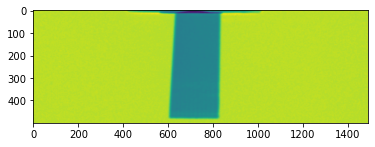

In [11]:
plt.imshow(proj[0])

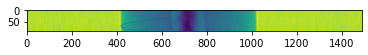

In [13]:
plt.imshow(proj[:,0,:])

## Crop data (from center)
- num_col: cropped out columns number

In [6]:
num_col = 600
tot_col = proj.shape[2]
proj_crop = proj[:,:,tot_col//2-num_col//2:tot_col//2+num_col//2]

## Calculate rotation center
- tomopy.find_center_pc(first angle, second angle, tol)

In [7]:
rot_center_est=tomopy.find_center_pc(np.squeeze(proj_crop[0,:,:]), np.squeeze(proj_crop[90,:,:]), tol=0.5)
print('Estimated center of rotation %f' %rot_center_est)

Estimated center of rotation 271.500000


## Settings for reconstruction
- T, P, sharpness, snr_db: parameters of reconstruction, usually keep fixed. (Can be played with)
- angles_radian: convert angle into rad

In [8]:
T = 2.0
p = 1.2
sharpness = 0.0
snr_db = 30.0

angles_radian =  np.array(ang_list) * np.pi / 180 
center_offset= -(proj_crop.shape[2]/2 - rot_center_est)

In [9]:
rec_mbir = svmbir.recon(proj_crop, angles=angles_radian, weight_type='transmission', 
                        num_rows = num_col, num_cols = num_col, center_offset=center_offset, 
                        snr_db=snr_db, p=p, T=T, sharpness=sharpness, 
                        positivity=False, max_iterations=100, num_threads= 112, verbose=0)
# verbose: display of reconstruction: 0 is minimum, 1 is regular

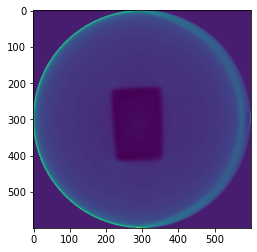

In [11]:
plt.imshow(rec_mbir[50]) # display one slice of reconstrucion

In [12]:
rec_crop = rec_mbir[:,180:430,200:380] # crop reconstruction ROI

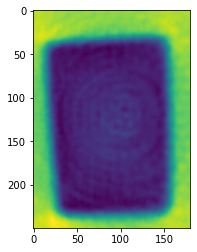

In [13]:
plt.imshow(rec_crop[50]) 

## Save cropped reconstruction

In [22]:
# change save path for your own
fname = '/netdisk/imaging/data_hfir/for_shimin/DOE_Mod/recons/rec02_crop/rec' 
dxchange.write_tiff_stack(rec_crop, fname=fname, start=z_start,overwrite=True)

## Load reconstruction

In [ ]:
rec_ls = glob.glob('/netdisk/imaging/data_hfir/for_shimin/DOE_Mod/recons/rec02/*')
# list all reonstructed slices
rec_ls.sort()

# load certain slice
# initiate reconstruction array
im = imread(rec_ls[0])
rec = np.zeros((len(rec_ls), im.shape[0], im.shape[1]))
for i in range(len(rec_ls)): # load all slices
    rec[i] = imread(rec_ls[i])

## Display from slide view

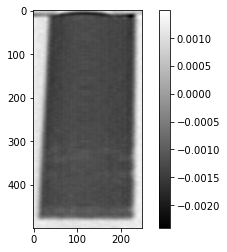

In [15]:
plt.imshow(rec_crop[:, :,50], cmap = 'gray',  )
plt.colorbar()

## Display cross section 

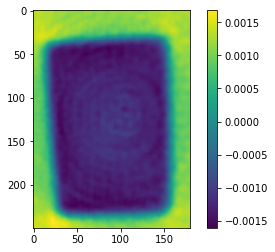

In [16]:
plt.imshow(rec_mbir[50,180:430,200:380] )
plt.colorbar()